In [ ]:
import gym
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.distributions import Categorical

from tqdm import tqdm, trange

In [ ]:
# Goal: learn right setting of weights to maximize the expected rewards
# Want an NN that outputs distribution over actions
class Agent(nn.Module):
    def __init__(self, n_actions, n_states, hidden_size):
        super(Agent, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_states, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),
            nn.Softmax() # b/c we want a distribution over action space
        )

    def forward(self, X):
        return self.net(X)

class Val(nn.Module):
    def __init__(self, n_states, hidden_size, out_size):
        super (Val, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_states, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size)
        )

    def forward(self, X):
        return self.net(X)


class VPG():
    def __init__(self,n_actions, n_states, hidden_size, buffer_size, learning_rate, batch_size, gamma):
        self.agent = Agent(n_actions, n_states, hidden_size)
        self.val = Val(n_states, hidden_size, 1)
        self.gamma = gamma
        self.states= []
        self.rewards=[]
        self.next_states=[]
        self.actions = []
        self.chosen_actions = []
        self.episode_rewards = []
        
        self.optim = torch.optim.Adam(self.agent.parameters(), lr=learning_rate)

    def add_observation(self, state, action, chosen_action, reward, next_state):
        self.states.append(state)
        self.actions.append(action)
        self.chosen_actions.append(chosen_action)
        self.rewards.append(reward)
        self.next_states.append(next_state)

    def get_avg_reward_for_episode(self):
        reward = sum(self.rewards)
        self.episode_rewards.append(reward)
        return reward


    def update(self):
        self.optim.zero_grad()
        rewards_to_go = np.sum([self.gamma**ix * np.array(self.rewards[ix]) for ix, each in enumerate(self.rewards)])
        sampler = Categorical(self.agent(torch.Tensor(self.states)))

        loss = -torch.sum(sampler.log_prob(torch.Tensor(self.chosen_actions)) * rewards_to_go)
        # print("LOSS",loss.shape)
        loss.backward()
        for param in self.agent.parameters():
            param.grad.data.clamp(-1,1)
        self.optim.step()



    def clear(self):
        self.states = []
        self.rewards = []
        self.next_states = []
        self.actions = []
        self.chosen_actions = []



        
    

In [ ]:
n_actions = 4
n_states = 8
hidden_size = 128
buffer_size = 1000000
learning_rate = 0.002
batch_size = 64
gamma = 0.99
model = VPG(n_actions, n_states, hidden_size, buffer_size, learning_rate, batch_size, gamma)
model.agent.load_state_dict(torch.load("./weights/chkpt_1_3000.pt"))



In [ ]:

env = gym.make("LunarLander-v2", render_mode="human")
for ep in (pbar:=tqdm(range(5000))): # num. episodes
   observation, info = env.reset()
   terminated, truncated = False, False
   num_steps = 0
   while not terminated and not truncated and num_steps < 300:
      actions = model.agent(torch.Tensor(observation))
      chosen_action = Categorical(actions).sample().item()
      next_observation, reward, terminated, truncated, info = env.step(chosen_action)

      model.add_observation(observation, actions, chosen_action, reward, next_observation)
      observation = next_observation
      num_steps+=1
   ep_reward = model.get_avg_reward_for_episode()
   model.update()
   model.clear()


   pbar.set_description("Ep: {} Reward: {:.3}".format(ep, ep_reward))
   if ep % 500 == 0 and ep != 0:
      torch.save(model.agent.state_dict(), f"chkpt_1_{ep}.pt")

   
   


   



      
env.close()

In [ ]:
torch.save(model.agent.state_dict(), "final_weights_1.pt")
torch.save(model.episode_rewards, "rewards.pt")
plt.plot(model.episode_rewards)

In [ ]:
rewards = []
model = VPG(n_actions, n_states, hidden_size, buffer_size, learning_rate, batch_size, gamma)
model.agent.load_state_dict(torch.load("./weights/chkpt_1_3000.pt"))
env = gym.make("LunarLander-v2", render_mode="human")
model.agent.eval()
with torch.no_grad():
    for ep in range(100):
        observation, info = env.reset()
        terminated, truncated = False, False
        accum = 0
        while not terminated and not truncated:
            actions = model.agent(torch.Tensor(observation))
            chosen_action = Categorical(actions).sample().item()
            next_observation, reward, terminated, truncated, info = env.step(chosen_action)
            accum += reward
            observation = next_observation
        rewards.append(accum)

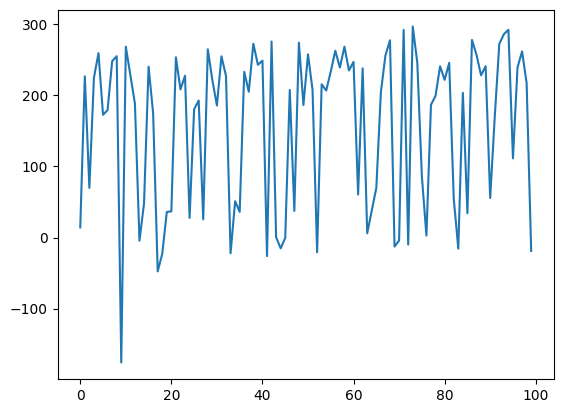

In [177]:
plt.plot(rewards)